In [1]:
!pip install pytorchvideo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 16.8 MB/s eta 0:00:00
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188685 sha256=cff47dc7dfbaa99ae1200f3af064b71e0541f0e5ccd41de49c9589f98afc5cc7
  Stored in directory: /root/.cache/pip/wheels/a4/6d/ae/d016375a73be141a0e11bb42289e2d0b046c35687fc8010ecc
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=1ad64530e9bcbe8ce5e2483352cf235ba960b5f1cb1eb33a1330ec04960b7f17
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel 

In [2]:
from tqdm import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from pytorchvideo.models.hub import slowfast_r101
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/MultiSportsFootball.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

In [5]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

In [39]:
class CONFIG:
  epochs = 10
  batch_size = 8
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  learning_rate = 1e-5
  num_workers = 2
  #classes = ['football shoot', 'football long pass', 'football short pass', 'football through pass', 'football cross', 'football dribble', 'football trap', 'football throw', 'football diving', 'football tackle', 'football steal', 'football clearance', 'football block', 'football press', 'football aerial duels']
  classes = ['football short pass', 'football diving']
  videos_per_class = 50

In [40]:
class2label = {class_name: i for i, class_name in enumerate(CONFIG.classes)}
label2class = {i: class_name for i, class_name in enumerate(CONFIG.classes)}

In [28]:
def get_files_and_class_names(path, num_classes):
    video_paths = list(path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths]

    path_per_class = collections.defaultdict(list)
    for p, c in zip(video_paths, classes):
        if c in CONFIG.classes:
          path_per_class[c].append(p)

    video_paths = []
    classes = []
    for c, paths in path_per_class.items():
        num_class_examples = min(len(paths), num_classes)
        paths = np.array(paths)
        indexes = np.linspace(0, len(paths) - 1, num_class_examples, dtype=int)
        class_paths = paths[indexes].tolist()
        video_paths.extend(class_paths)
        classes.extend([class2label[c] for _ in range(len(class_paths))])

    return video_paths, classes

In [62]:
# Custom Dataset class
class VideoDataset(Dataset):
    def __init__(self, file_paths, targets, transform=None):
        self.file_paths = file_paths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        video_frames = frames_from_video_file(self.file_paths[idx],
                                              n_frames=8, frame_step=2)

        label = self.targets[idx]

        video_frames = torch.FloatTensor(video_frames)  # Shape: (num_frames, channels, height, width)

        if self.transform:
            video_frames = torch.transpose(video_frames, 0, 1)
            video_frames = self.transform(video_frames)
            video_frames = torch.transpose(video_frames, 0, 1)

        return video_frames, torch.tensor(label, dtype=torch.long)

def format_frames(frame, output_size):
    """Format frames to tensor with specified size"""
    frame = cv2.resize(frame, output_size)
    frame = frame / 255.0
    return frame

def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=4):
    """Extract frames from video file"""
    result = []
    src = cv2.VideoCapture(str(video_path))

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))

    src.release()

    result = np.array(result)
    result = np.transpose(result, (3, 0, 1, 2))  # (T, C, H, W) format
    return result

In [52]:
# Model definition
class VideoClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VideoClassifier, self).__init__()
        self.model = models.video.r2plus1d_18(weights=models.video.R2Plus1D_18_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        # Freeze the pre-trained parameters
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc.weight.requires_grad = True
        self.model.fc.bias.requires_grad = True

    def forward(self, x):
        x = self.model(x)

        return x


In [31]:
# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for videos, labels in tqdm(dataloader):
        videos, labels = videos.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in tqdm(dataloader):
            videos, labels = videos.to(device), labels.to(device)

            outputs = model(videos)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc, all_preds, all_labels

In [32]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [33]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history['train_loss'], label = 'train')
  ax1.plot(history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history['train_loss'] + history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history['train_acc'],  label = 'train')
  ax2.plot(history['val_acc'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 100])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

In [34]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

In [53]:
# Load dataset
train_paths, train_classes = get_files_and_class_names(pathlib.Path('./train'), 150)
val_paths, val_classes = get_files_and_class_names(pathlib.Path('./valid'), 50)

# Create datasets and dataloaders

train_dataset = VideoDataset(train_paths, train_classes)
val_dataset = VideoDataset(val_paths, val_classes)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG.batch_size,
    shuffle=True,
    num_workers=CONFIG.num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG.batch_size,
    shuffle=False,
    num_workers=CONFIG.num_workers
)

In [54]:
# Main training loop
def main(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=3, factor=0.5
    )

    # Training loop
    best_val_acc = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(CONFIG.epochs):
        print(f'Epoch {epoch+1}/{CONFIG.epochs}')

        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, CONFIG.device
        )

        val_loss, val_acc, all_preds, all_labels = validate(
            model, val_loader, criterion, CONFIG.device
        )

        # Update learning rate
        scheduler.step(val_loss)


        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            checkpoint_path = 'best.pt'

            torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            }, checkpoint_path)

        torch.save({
          'epoch': epoch + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          }, 'last.pt')

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

    return history

In [55]:
# Initialize model
model = VideoClassifier(num_classes=len(CONFIG.classes)).to(CONFIG.device)

In [56]:
history = main(model)

Epoch 1/10


100%|██████████| 12/12 [00:21<00:00,  1.81s/it]


Train Loss: 0.6123 Train Acc: 61.31%
Val Loss: 0.5364 Val Acc: 77.53%
Epoch 2/10


100%|██████████| 12/12 [00:21<00:00,  1.82s/it]


Train Loss: 0.3925 Train Acc: 86.86%
Val Loss: 0.3546 Val Acc: 86.52%
Epoch 3/10


100%|██████████| 12/12 [00:21<00:00,  1.80s/it]


Train Loss: 0.2651 Train Acc: 94.53%
Val Loss: 0.2697 Val Acc: 89.89%
Epoch 4/10


100%|██████████| 12/12 [00:21<00:00,  1.81s/it]


Train Loss: 0.2001 Train Acc: 94.89%
Val Loss: 0.2519 Val Acc: 89.89%
Epoch 5/10


100%|██████████| 12/12 [00:22<00:00,  1.84s/it]


Train Loss: 0.1542 Train Acc: 97.08%
Val Loss: 0.2089 Val Acc: 92.13%
Epoch 6/10


100%|██████████| 12/12 [00:22<00:00,  1.85s/it]


Train Loss: 0.1800 Train Acc: 95.62%
Val Loss: 0.2105 Val Acc: 92.13%
Epoch 7/10


100%|██████████| 12/12 [00:21<00:00,  1.80s/it]


Train Loss: 0.1387 Train Acc: 96.72%
Val Loss: 0.1696 Val Acc: 93.26%
Epoch 8/10


100%|██████████| 12/12 [00:21<00:00,  1.81s/it]


Train Loss: 0.0849 Train Acc: 98.18%
Val Loss: 0.2054 Val Acc: 93.26%
Epoch 9/10


100%|██████████| 12/12 [00:21<00:00,  1.81s/it]


Train Loss: 0.0999 Train Acc: 98.54%
Val Loss: 0.1643 Val Acc: 92.13%
Epoch 10/10


100%|██████████| 12/12 [00:21<00:00,  1.81s/it]


Train Loss: 0.1203 Train Acc: 95.26%
Val Loss: 0.1918 Val Acc: 92.13%


In [18]:
history = main(model)

Epoch 1/10


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Train Loss: 1.4792 Train Acc: 30.36%
Val Loss: 1.2915 Val Acc: 31.45%
Epoch 2/10


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Train Loss: 1.1703 Train Acc: 38.06%
Val Loss: 1.0667 Val Acc: 52.20%
Epoch 3/10


100%|██████████| 20/20 [00:18<00:00,  1.05it/s]


Train Loss: 0.9605 Train Acc: 62.75%
Val Loss: 0.9202 Val Acc: 67.30%
Epoch 4/10


100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Train Loss: 0.8144 Train Acc: 71.26%
Val Loss: 0.8393 Val Acc: 68.55%
Epoch 5/10


100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Train Loss: 0.7216 Train Acc: 76.11%
Val Loss: 0.7806 Val Acc: 71.07%
Epoch 6/10


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Train Loss: 0.6333 Train Acc: 80.77%
Val Loss: 0.7627 Val Acc: 71.70%
Epoch 7/10


100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Train Loss: 0.5885 Train Acc: 80.97%
Val Loss: 0.7512 Val Acc: 71.70%
Epoch 8/10


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Train Loss: 0.5327 Train Acc: 84.41%
Val Loss: 0.7238 Val Acc: 74.21%
Epoch 9/10


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Train Loss: 0.4732 Train Acc: 85.63%
Val Loss: 0.7152 Val Acc: 74.84%
Epoch 10/10


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Train Loss: 0.4231 Train Acc: 91.30%
Val Loss: 0.6794 Val Acc: 76.73%


In [57]:
model.load_state_dict(torch.load('best.pt', weights_only=True)['model_state_dict'])

<All keys matched successfully>

100%|██████████| 12/12 [00:21<00:00,  1.76s/it]


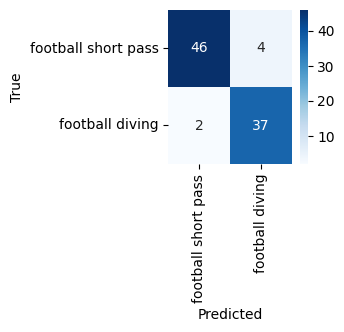

In [58]:
criterion = nn.CrossEntropyLoss()

val_loss, val_acc, all_preds, all_labels = validate(
  model, val_loader, criterion, CONFIG.device
)

plot_confusion_matrix(all_labels, all_preds, CONFIG.classes)

100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


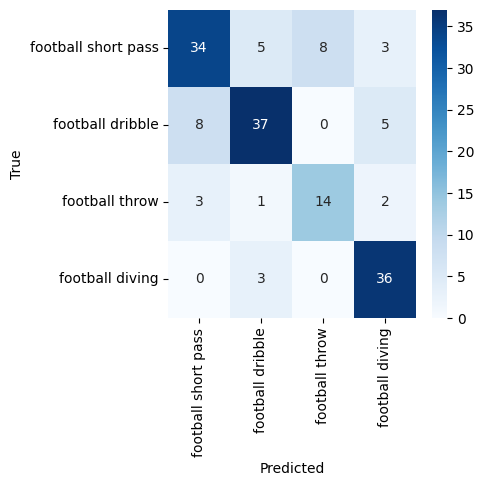

In [20]:
criterion = nn.CrossEntropyLoss()

val_loss, val_acc, all_preds, all_labels = validate(
  model, val_loader, criterion, CONFIG.device
)

plot_confusion_matrix(all_labels, all_preds, CONFIG.classes)

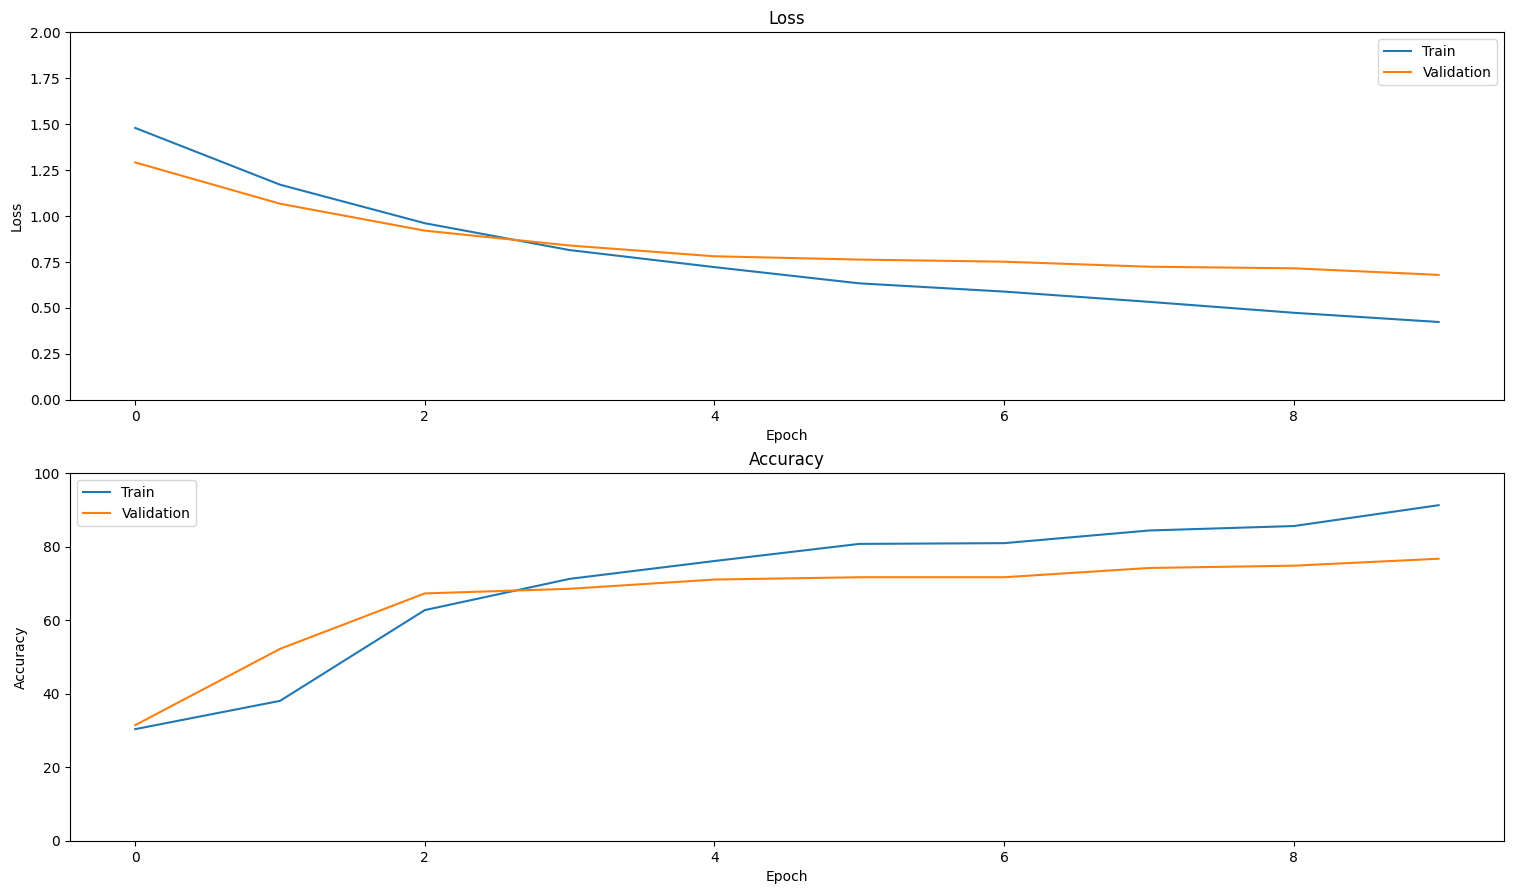

In [21]:
plot_history(history)

In [22]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    if (tp[i] + fp) == 0:
      precision[labels[i]] = 0
    else:
      precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

    if (tp[i] + fn) == 0:
      recall[labels[i]] = 0
    else:
      recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [59]:
precision, recall = calculate_classification_metrics(all_labels, all_preds, CONFIG.classes)

In [60]:
precision

{'football short pass': 0.9583333333333334,
 'football diving': 0.9024390243902439}

In [24]:
precision

{'football short pass': 0.7555555555555555,
 'football dribble': 0.8043478260869565,
 'football throw': 0.6363636363636364,
 'football diving': 0.782608695652174}

In [61]:
recall

{'football short pass': 0.92, 'football diving': 0.9487179487179487}

In [25]:
recall

{'football short pass': 0.68,
 'football dribble': 0.74,
 'football throw': 0.7,
 'football diving': 0.9230769230769231}